In [2]:
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_file = os.path.join("workspace", "seqlab-latest", "test.csv")
batch_size = 8
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


c:\.virtualenv\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Preparing Data test: 100%|██████████| 6961/6961 [00:53<00:00, 130.01it/s]


In [1]:
# somehow I do PCA analysis.
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)
n = pretrained.DNABERT_SL.from_pretrained(
    pretrained_path,
    json.load(open(model_config_path, "r"))
)
checkpoint = torch.load(
    os.path.join("run", "latest", "latest", "checkpoint.pth"), 
    map_location="cuda:0") # force to cuda:0 device
m.load_state_dict(checkpoint.get("model"))
n.load_state_dict(checkpoint.get("model"))
n.save_pretrained(save_pretrained_model_path)

Some weights of the model checkpoint at pretrained\3-new-12w-0 were not used when initializing DNABERT_SL: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'bert.pooler.dense.bias', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing DNABERT_SL from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DNABERT_SL from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DNABERT_SL were not initialized from the model checkpoint at pretrained\3-new-12w-0 and are newly initial

In [12]:
tokenizer.cls_token_id

2

In [2]:
# get all token predictions and their corresponding bert value.

from utils.seqlab import id2label
import pandas as pd
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_log = os.path.join("prediction", "log", "prediction_log_complete.csv")
df = pd.read_csv(test_log)
all_correct_df = df[df["avg_f1_score"] == 1]
path = os.path.join("prediction", "log", "avg_f1_1.csv")
all_correct_df.to_csv(path, index=False)

m.eval()
m.to(device)
arr_token_ids, arr_target_ids, arr_bert_outputs, arr_prediction_ids = [], [], [], []
tokens, target_tokens = [], []
for step, row in tqdm(all_correct_df.iterrows(), total=all_correct_df.shape[0], desc="Testing"):
    # input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
    input_ids = [int(a) for a in row["input_ids"].split(" ")]
    input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
    b_input_ids = torch.tensor([input_ids]).to(device)
    attn_mask = [0 for a in range(len(b_input_ids))]
    b_attn_mask = torch.tensor([attn_mask]).to(device)
    target_ids = [int(a) for a in row["target_ids"].split(" ")]
    target_ids = [-100] + target_ids + [-100]
    b_target_ids = torch.tensor([target_ids]).to(device)
    with torch.no_grad():
        b_out, b_out_bert, b_out_head = m(b_input_ids, b_attn_mask)
        for input_ids, target_ids, bert, out in zip(b_input_ids, b_target_ids, b_out_bert, b_out):
            pred_ids = torch.argmax(out, 1)
            for i, j, k, p in zip(input_ids, target_ids, bert, pred_ids):
                arr_token_ids.append(i.item())
                arr_target_ids.append(j.item())
                arr_prediction_ids.append(p.item())
                arr_bert_outputs.append(" ".join([str(a) for a in k.tolist()]))

df = pd.DataFrame(data={
    "token_id": arr_token_ids,
    "prediction_id": arr_prediction_ids,
    "target_id": arr_target_ids,
    "bert_value": arr_bert_outputs
})
df.head(5)

Testing: 100%|██████████| 45/45 [01:01<00:00,  1.36s/it]


,token_id,prediction_id,target_id,bert_value
0,2,0,-100,0.8319421410560608 1.663792371749878 -0.938970...
1,45,0,0,0.304279088973999 1.5116431713104248 -0.623651...
2,37,0,0,0.3083809018135071 1.3372265100479126 -1.03914...
3,8,0,0,0.37082692980766296 1.034065842628479 -0.66065...
4,20,0,0,0.07689828425645828 1.4326666593551636 -0.0830...


In [3]:
print(f"all {df.shape}")
special_pred_df = df[df["target_id"] < 0]
print(f"special token prediction {special_pred_df.shape}")
clean_df = df[df["target_id"] >= 0]
print(f"clean prediction {clean_df.shape}")
all_clear_df = clean_df[clean_df["prediction_id"] == clean_df["target_id"]]
print(f"all clear prediction {all_clear_df.shape}")
all_clear_df["prediction_id"].unique()


all (23040, 4)
special token prediction (90, 4)
clean prediction (22950, 4)
all clear prediction (22950, 4)


array([0, 1, 4, 7, 5, 3], dtype=int64)

In [4]:
# consider each element of bert value is feature. oh boy.
feature_df = df.apply(lambda x: x["bert_value"].split(" "), axis=1, result_type="expand")
print(feature_df.shape)
# feature_count = 768
feature_count = feature_df.shape[1]
rename_dictionary = {}
for i in range(feature_count):
    rename_dictionary[i] = f"feature-{i}"
renamed_feature_df = feature_df.rename(columns=rename_dictionary)
renamed_feature_df.head(2)


(23040, 768)


,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,0.8319421410560608,1.663792371749878,-0.938970148563385,1.52774178981781,0.9459241032600403,-0.8467956185340881,-1.2615801095962524,-1.08918035030365,-0.6464066505432129,0.029933014884591103,...,1.7318533658981323,-0.030127957463264465,1.2412145137786865,-1.4076619148254395,-0.4426130950450897,-0.3106485605239868,0.4021283984184265,-1.595903992652893,0.33699753880500793,-0.012605451047420502
1,0.304279088973999,1.5116431713104248,-0.6236518025398254,1.331417441368103,0.9176082015037537,-0.5812518000602722,-1.3384363651275635,-1.1388977766036987,-1.5663477182388306,-0.2642268240451813,...,1.5182241201400757,-0.10070624202489853,1.5866979360580444,-1.0598236322402954,-0.29061949253082275,-0.19450126588344574,-0.18322746455669403,-1.4730931520462036,0.31481635570526123,-0.08494318276643753


In [6]:
# merge two dataframe: df and feature frame.
for i in range(768):
    fcol = f"feature-{i}"
    df[fcol] = renamed_feature_df[fcol]
df.to_csv(
    os.path.join("prediction", "log", "token_representation_analysis.csv"),
    index=False
)


c:\.virtualenv\sequence-processing\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
import pandas as pd
import os

df = pd.read_csv(os.path.join("prediction", "log", "token_representation_analysis.csv"))
print(df.shape)
df.head(5)

(23040, 772)


,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,0,-100,0.8319421410560608 1.663792371749878 -0.938970...,0.831942,1.663792,-0.938970,1.527742,0.945924,-0.846796,...,1.731853,-0.030128,1.241215,-1.407662,-0.442613,-0.310649,0.402128,-1.595904,0.336998,-0.012605
1,45,0,0,0.304279088973999 1.5116431713104248 -0.623651...,0.304279,1.511643,-0.623652,1.331417,0.917608,-0.581252,...,1.518224,-0.100706,1.586698,-1.059824,-0.290619,-0.194501,-0.183227,-1.473093,0.314816,-0.084943
2,37,0,0,0.3083809018135071 1.3372265100479126 -1.03914...,0.308381,1.337227,-1.039147,1.501680,1.031719,-0.679972,...,1.508862,-0.346619,1.414293,-0.912273,-0.380145,-0.241054,0.083394,-1.618439,0.551469,-0.188681
3,8,0,0,0.37082692980766296 1.034065842628479 -0.66065...,0.370827,1.034066,-0.660652,1.124182,1.205785,-0.358244,...,1.707825,-0.066200,1.339012,-1.099447,-0.156992,-0.937326,0.231542,-1.515167,0.352921,-0.209426
4,20,0,0,0.07689828425645828 1.4326666593551636 -0.0830...,0.076898,1.432667,-0.083092,1.174400,1.252108,-0.427998,...,1.596214,-0.193219,1.030890,-1.363554,-0.464590,-1.003220,0.365821,-1.409484,0.092443,0.078692


In [62]:
# pca with sklearn.
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
n_components = 2
# feature_df = df[df["prediction_id"] == df["target_id"]]
feature_df = df[[f"feature-{i}" for i in range(768)]]
feature_std = (df - df.mean()) / df.std()
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(feature_std)
principal_components_df = pd.DataFrame(data=principal_components, columns=[f"nf-{i}" for i in range(n_components)])
print(principal_components_df.shape)

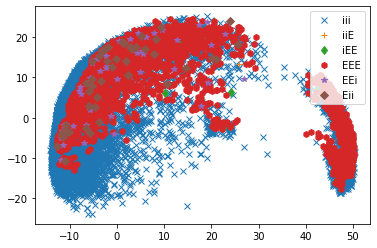

In [58]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary

# merge pca analysis with existing df.
df["nf-0"] = principal_components_df["nf-0"]
df["nf-1"] = principal_components_df["nf-1"]

unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(unique_prediction_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        j,
        label=Index_Dictionary[i]
    )

plt.xlabel = "pca 1"
plt.ylabel = "pca 2"
plt.legend(loc="upper right")
plt.show()


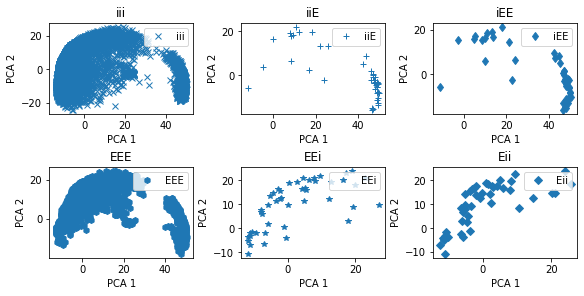

In [60]:
nrows = 2
ncols = 3
idx = 0
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for r in range(nrows):
    for c in range(ncols):
        i = unique_prediction_ids[idx]
        j = markers[idx]
        filtered_df = df[df["prediction_id"] == i]
        x = filtered_df["nf-0"]
        y = filtered_df["nf-1"]
        axes[r][c].plot(
            x, 
            y,
            j,
            label=f"{Index_Dictionary[i]}"
        )
        axes[r][c].set_xlabel("PCA 1")
        axes[r][c].set_ylabel("PCA 2")
        axes[r][c].set_title(f"{Index_Dictionary[i]}")
        axes[r][c].legend(loc="upper right")
        idx += 1


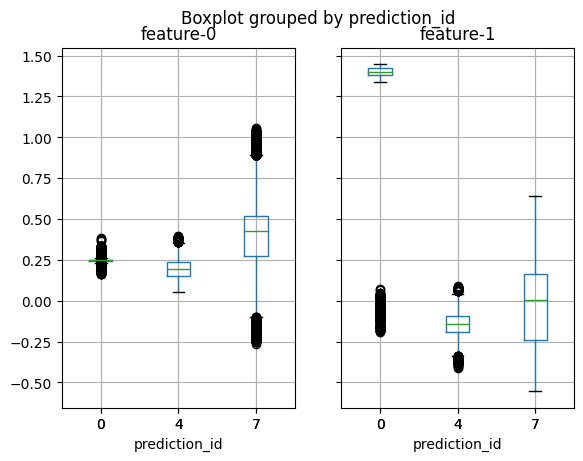

In [20]:
boxplot = df.boxplot(by="prediction_id", column=["feature-0", "feature-1"], layout=(1, 2))

array([<AxesSubplot:title={'center':'feature-1'}, xlabel='prediction_id'>,
       <AxesSubplot:title={'center':'feature-2'}, xlabel='prediction_id'>],
      dtype=object)

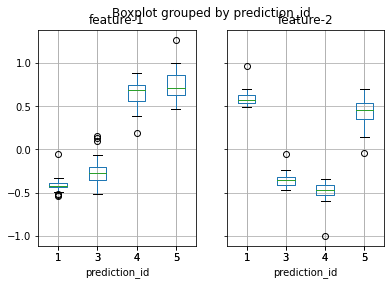

In [8]:
# load dataset.
from utils.seqlab import splice_site_ids, Index_Dictionary
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

token_reps_df = pd.read_csv(
    os.path.join("prediction", "log", "token_representation_analysis.csv")
)
ss_token_reps_df = token_reps_df[token_reps_df["prediction_id"].isin(splice_site_ids)]


array([<AxesSubplot:title={'center':'feature-1'}, xlabel='prediction_id'>,
       <AxesSubplot:title={'center':'feature-2'}, xlabel='prediction_id'>],
      dtype=object)

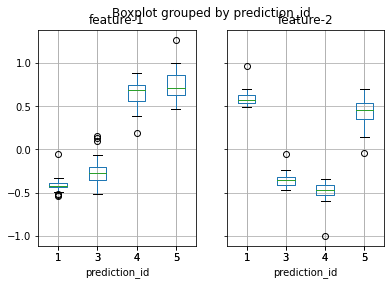

In [9]:
# boxplot.

X = ss_token_reps_df[[f"feature-{i}" for i in range(768)]].to_numpy()
labels = ss_token_reps_df["prediction_id"].to_numpy()
ss_token_reps_df.boxplot(by="prediction_id", column=["feature-1", "feature-2"])


eigen values and vector dimension (768,) (768, 768)
idx (768,), sorted eigen vector (768, 768)


c:\.virtualenv\sequence-processing\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


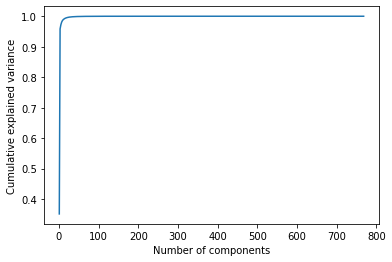

In [30]:
# compute covariance matrix.
X = StandardScaler().fit_transform(X)
cov = (X.T @ X) / (X.shape[0] - 1)

# performing eigen-decomposition.
eig_values, eig_vectors = np.linalg.eig(cov)
print("eigen values and vector dimension", eig_values.shape, eig_vectors.shape)

# determine which principal components to select.
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]
print(f"idx {idx.shape}, sorted eigen vector {sorted_eig_vectors.shape}")

cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
# plt.xticks(xint)
# plt.xlim(1, 768, 1)
plt.plot(xint, cumsum)
plt.show()


In [33]:
print(X.shape, sorted_eig_vectors[:, :2].shape)
res = np.dot(X, sorted_eig_vectors[:, :2]).shape
res

(180, 768) (768, 2)


(180, 2)

(180, 2)
1 iiE
3 Eii
4 iEE
5 EEi


TypeError: ufunc 'hypot' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

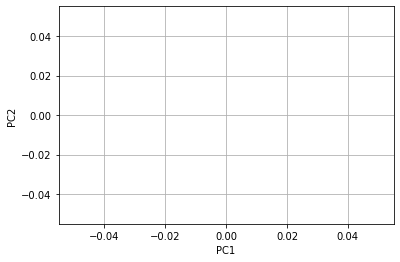

In [41]:
# compute the transformation.
eig_scores = np.dot(X, sorted_eig_vectors[:, :2])
colors = ["blue", "red", "green", "yellow", "gray", "black"]

print(eig_scores.shape)
def biplot(score, coeff, labels):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    for i, u in zip(splice_site_ids, [Index_Dictionary[a] for a in splice_site_ids]):
        print(i, u)
        xi = [
            score[j, 0] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        yi = [
            score[j, 1] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        plt.scatter(xi, yi, c=colors[i], label=u)
    for i in range(n):
        plt.arrow(
            0, 0, coeff[i, 0], coeff[i, 1], color="r", head_width=0.05, head_length=0.1
        )
        plt.text(
            coeff[i, 0] * 1.35,
            coeff[i, 1] * 1.35,
            labels[i],
            color="g",
            ha="center",
            va="center",
        )


plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(eig_scores, sorted_eig_vectors, [f"feature-{i}" for i in range(768)])
plt.legend()

In [20]:
ndf[ndf["comparison"] == 0]

,token,target,prediction,bert_value,comparison
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...,0
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...,0
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...,0
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...,0
5,GGA,iEE,iiE,-0.06882086396217346 0.0999293401837349 1.1488...,0
...,...,...,...,...,...
175,GGT,Eii,iiE,-0.12136223912239075 0.24540439248085022 1.074...,0
176,AGG,iiE,Eii,0.19183388352394104 -0.3378389775753021 0.5174...,0
177,GGA,iEE,EEE,0.17814867198467255 -0.09485137462615967 1.077...,0
178,AGG,EEi,EEE,0.021793914958834648 0.720974862575531 0.61671...,0


In [19]:
ndf.to_csv(
    os.path.join("motif_analysis", "token_analysis", "df-F1=1.csv"), 
    index=False
)

In [21]:
# something weird.
import os
import pandas as pd

path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
tokens, predictions, targets = [], [], []
df = pd.read_csv(path)
for step, r in df.iterrows():
    input_tokens = r["input_tokens"].split(" ")
    prediction_tokens = r["prediction_tokens"].split(" ")
    target_tokens = r["target_tokens"].split(" ")

    for i, j, k in zip(input_tokens, prediction_tokens, target_tokens):
        tokens.append(i)
        predictions.append(j)
        targets.append(k)

df = pd.DataFrame(data={
    "token": tokens,
    "prediction": predictions,
    "target": targets
})
df.head(5)

,token,prediction,target
0,ACT,iii,iii
1,CTT,iii,iii
2,TTT,iii,iii
3,TTT,iii,iii
4,TTC,iii,iii


In [23]:
print(df.shape)
print(df[df["prediction"] == df["target"]].shape)
print(df[df["prediction"] != df["target"]].shape)

(22950, 3)
(22950, 3)
(0, 3)
